## Introducción al dataset

Para este trabajo, hemos escogido un dataset que consta de 101 animales de un zoo. Hay 16 variables booleanas que describen en cierta medida al animal. Es decir, cada una de esas variables se corresponde con un atributo (pelo, plumas, depredador) que será un 1 si posee dicha cualidad y un 0 si no la posee. 

El objetivo de este trabajo es aplicar un modelo SLP (Single Layer Perceptron o *Perceptron de Una Sola Capa*) que clasifique cada animal en una de las clases, dependiendo de los atributos que posea.

---

## 1. Importar librerías

In [1]:
import tensorflow.compat.v1 as tf # Usaremos la versión 1 de Tensorflow por simplicidad
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

2022-11-10 10:19:11.002158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 10:19:11.364398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 10:19:11.364429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-10 10:19:11.429816: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 10:19:12.696113: W tensorflow/stream_executor/platform/de

---

## 2. Explorar el dataset

### 2.1 - Importar dataset

In [2]:
zoo = pd.read_csv('zoo.csv')


# Mostramos las primeras 5 filas para visualizar el dataset
zoo.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


### 2.2 - Leer/interpretar dataset

In [3]:
print(f'Este dataset contiene:\n - {len(zoo)} animales (filas)\n - {max(zoo["class_type"])} clases de animales\n - {len(zoo.columns) -2} atributos para cada animal (columnas)')

Este dataset contiene:
 - 101 animales (filas)
 - 7 clases de animales
 - 16 atributos para cada animal (columnas)


Es importante mencionar que las 7 clases de animales en este dataset se corresponden con: mamíferos, aves, reptiles, peces, amfibios, insectos e invertebrados.

###### Veamos cuantos animales hay para cada clase

[Text(0.5, 0, 'Tipos de clases'), Text(0, 0.5, 'Número de animales')]

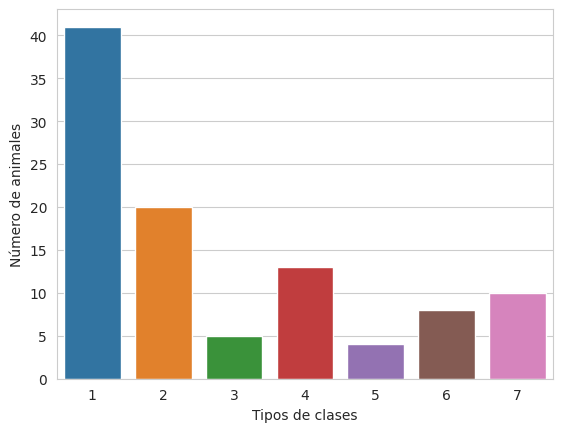

In [4]:
sns.set_style('whitegrid') # Seleccionamos el estilo de las gráficas en Seaborn
ax = sns.countplot(zoo, x = 'class_type') # Histograma de las clases
ax.set(xlabel='Tipos de clases', ylabel='Número de animales')

### 2.3 - Correlaciones

Al mostrar las correlaciones entre atributos, podemos ver alguna relación interesante sobre como llegará a actuar el modelo de Machine Learning al entrenarlo

<AxesSubplot: >

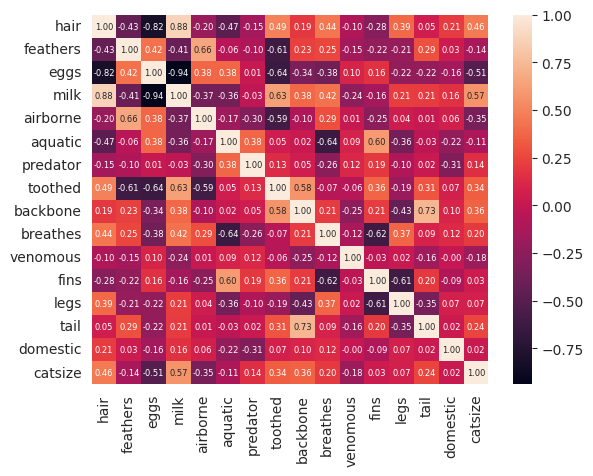

In [5]:
# Con iloc[] tomaremos solo los datos numéricos del dataset
# Obviando los nombres de los animales y las clases
data = zoo.iloc[:,1:-1]
corr = data.corr()
sns.heatmap(corr, annot=True, annot_kws={'size':6}, fmt = '.2f')

---

## 3. Preparación de los datos para el modelo de ML

 ### 3.1 - Dividir dataset entre Feature data y Label data

In [6]:
x_data = zoo.iloc[:,:-1] # Datos sin la columna que indica la clase del animal
y_data = zoo.iloc[:,-1:] # Solo la columna de clase del animal para comparar con los resultados

In [7]:
# Comprobamos que las dimensiones son correctas
print("Feature Data:", x_data.shape)
print("Label Data:", y_data.shape)

Feature Data: (101, 17)
Label Data: (101, 1)


### Dividir entre Train set y Test set

Dividiremos nuestros datos en 2: el 70% será usado para entrenar a la red neuronal (*Train set*) y el 30% restante será usado para comprobar su correcto funcionamiento en lo que llamaremos *Test set*

Usamos la función *train_test_split()* de la librería **sklearn.model_selection**

In [8]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42, stratify=y_data)

In [9]:
# Comprobamos que las dimensiones son correctas
print("Training set :", train_x.shape)
print("Testing set:", test_x.shape)

Training set : (70, 17)
Testing set: (31, 17)


La columna con con los nombres de animales la guardaremos en una variable y eliminaremos de las matrices actuales de datos. La razón de no haberlo hecho antes reside en que hemos "randomizado" el orden de los animales y así, si se quisiera, podríamos seguir identificando a todos los animales

In [10]:
train_name = train_x['animal_name']
test_name = test_x['animal_name']

train_x = train_x.iloc[:,1:]
test_x = test_x.iloc[:,1:]

# Volvemos a comprobar que las dimensiones son correctas
print("El 'train set' tiene las dimensiones:",train_x.shape)
print("El 'test set' tiene las dimensiones:",test_x.shape)

El 'train set' tiene las dimensiones: (70, 16)
El 'test set' tiene las dimensiones: (31, 16)


## 4. Creación del modelo SLP

Es importante mencionar que a partir de aquí usaremos las funciones de Tensorflow por su simplicidad, sin embargo, esto solo es una manera de hacerlo y no es necesario ya que también hay parte del código que se podría hacer con *numpy*.

### 4.1 - Asignación de variables dinámica con *placeholder*

Un **placeholder** es una variable en Tensorflow a la que se le asignarán datos más adelante. Nos permite crear procesos u operaciones sin necesidad de datos.

In [11]:
# Debemos desactivar eager_execution porque la función que usaremos no es compatible
tf.disable_eager_execution()

X = tf.placeholder(tf.float32, [None,16]) 
Y = tf.placeholder(tf.int32, [None, 1])

### 4.2 - One-hot encoding

Para este problema, usaremos lo que se conoce como *one-hot encoding*. Es una manera de analizar los datos basada en pasar datos categóricos a datos numéricos muy conveniente cuando el resultado de nuestra predicción incluye más de dos opciones. Como en nuestro caso implica determinar en cual de las 7 clases se encuentra un animal, nos facilitará la tarea. Para ello, usaremos la función *one_hot* de la librería Tensorflow

In [12]:
Y_one_hot = tf.one_hot(Y,7)
Y_one_hot = tf.reshape(Y_one_hot, [-1,7])

### 4.3 - Inicializar valores de *weight* y *bias*

Inicializamos los valores de manera aleatoria y definimos las variables de *weight* y *bias* con la función Variable() de Tensorflow.

In [13]:
W = tf.Variable(tf.random_normal([16, 7],seed=0), name='weight')
b = tf.Variable(tf.random_normal([7],seed=0), name='bias')

In [14]:
logits = tf.matmul(X, W) + b # Donde matmul es una función de Tensorflow para multiplicar matrices

# Normalizamos nuestra función clasificadora inicial
hypothesis = tf.nn.softmax(logits)

In [15]:
# Definimos la función de coste (cost function) de cada elemento de X
cost_i = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y_one_hot)
cost = tf.reduce_mean(cost_i)

In [16]:
# Entrenamos el modelo usando el descenso del gradiente
# de manera que disminuímos la función de coste a una frecuencia de 0.05.
train  = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(cost)

In [17]:
prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Donde:
- *prediction*: Es el índice del valor máximo de cada fila, que se corresponde con el output (la clase del animal), lo logramos recorriendo las filas de nuestro tensor **hypothesis** y encontrando el mayor valor/*weight*.
- *correct_prediction*: Compara nuestra predicción con el valor esperado (relación *True/False*)
- *accuracy*: Indica el porcentaje de aciertos. Para ello, primeramente pasamos nuestras predicciones de *True/False* a *1/0* con la función tf.cast() y hacemos la media. 

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # Inicializamos las variables globales
    for step in range(5001): # Realizaremos 5001 iteraciones para entrenar el modelo
        
        # Realizamos el descenso del gradiente introduciendo los valores de
        # train_x y train_y a los placeholders X e Y.
        sess.run(train, feed_dict={X: train_x, Y: train_y})
        
        # Mostramos cada 1000 iteraciones el error y la precisión
        if step % 1000 == 0:
            # Ejecutamos las funciones de coste y accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
            print("Iteración: {:5}\tError: {:.3f}\tPrecisión: {:.2%}".format(step, loss, acc))
            
    # Indicamos la precisión final del modelo
    train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
    
    # Ejecutamos el modelo con los datos del *test set*
    test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
    print(f'Precisión en el entrenamiento = {train_acc*100:.2f}%')
    print(f'Precisión en el test = {test_acc*100:.2f}%')

2022-11-10 10:19:17.387392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-10 10:19:17.387640: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-10 10:19:17.387672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (svik): /proc/driver/nvidia/version does not exist
2022-11-10 10:19:17.388968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 10:19:17.395644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass 

Iteración:     0	Error: 3.402	Precisión: 30.00%
Iteración:  1000	Error: 0.135	Precisión: 87.14%
Iteración:  2000	Error: 0.076	Precisión: 90.00%
Iteración:  3000	Error: 0.054	Precisión: 90.00%
Iteración:  4000	Error: 0.043	Precisión: 90.00%
Iteración:  5000	Error: 0.037	Precisión: 90.00%
Precisión en el entrenamiento = 90.00%
Precisión en el test = 93.55%


## 5. Predicción del test

Mostramos los resultados finales creando un DataFrame con pandas

In [21]:
res = pd.DataFrame()
res['Animal'] = test_name
res['Predicción clase'] = test_predict
res['Clase original'] = test_y
res['Correcto'] = test_correct

# Mostramos el DataFrame
res

,Animal,Predicción clase,Clase original,Correcto
100,wren,2,2,True
58,penguin,2,2,True
43,lark,2,2,True
21,duck,2,2,True
10,cheetah,1,1,True
40,housefly,6,6,True
50,mongoose,1,1,True
4,boar,1,1,True
87,swan,2,2,True
80,slowworm,3,3,True
